*Material adapted from: http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/*

March, 2016

#XGBoost. KAGGLE COMPETITION: BNP Paribas Cardif Claims Management


##INDEX<a id='index'></a>

0.[ **INTRODUCTION**](#0)

0.1[ Notebook's main goal](#0.1)

0.2[ About the competition. Data used](#0.2)

0.3[ About XGBoost](#0.3)
    

1.[ **IMPORT DATA AND PACKAGES**](#1)


2.[ **MODEL: XGBOOST**](#2)

[Go to index](#index)

##0. INTRODUCTION <a id='0'></a>

###0.1 Notebook's main goal <a id='0.1'></a>

The goal of this notebook is to use XGBoost to predict customer satisfaction, in the context of BNP Paribas Cardif Claims Management's Kaggle competition.

[Go to index](#index)

###0.2 About the competition. Data used <a id='0.2'></a>

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management


Downloaded data:
- `train.csv`
- `test.csv`

[Go to index](#index)

###0.3 About XGBoost <a id='0.3'></a>

Review:
- Complete Guide to Parameter Tuning in Gradient Boosting (GBM) in Python (http://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)
- Complete Guide to Parameter Tuning in XGBoost (with codes in Python) (http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)


To install XGBoost in a Windows 8 laptop I followed these instructions (from Disco4ever answer at http://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform):

"Note that as of the most recent release the Microsoft Visual Studio instructions no longer seem to apply as this link returns a 404 error:

https://github.com/dmlc/xgboost/tree/master/windows

You can read more about the removal of the MSVC build from Tianqi Chen's comment here.

So here's what I did to finish a 64-bit build on Windows:

    Download and install MinGW-64: http://sourceforge.net/projects/mingw-w64/
    On the first screen of the install prompt make sure you set the Architecture to x86_64 and the Threads to win32
    I installed to C:\mingw64 (to avoid spaces in the file path) so I added this to my PATH environment variable: C:\mingw64\mingw64\bin
    I also noticed that the make utility that is included in bin\mingw64 is called mingw32-make so to simplify things I just renamed this to make
    Open a Windows command prompt and type gcc. You should see something like "fatal error: no input file"
    Next type make. You should see something like "No targets specified and no makefile found"
    Type git. If you don't have git, install it and add it to your PATH.

These should be all the tools you need to build the xgboost project. To get the source code run these lines:

    cd c:\
    git clone --recursive https://github.com/dmlc/xgboost
    cd xgboost
    git submodule init
    git submodule update
    cp make/mingw64.mk config.mk
    make -j4

Note that I ran this part from a Cygwin shell. If you are using the Windows command prompt you should be able to change cp to copy and arrive at the same result. However, if the build fails on you for any reason I would recommend trying again using cygwin.

If the build finishes successfully, you should have a file called xgboost.exe located in the project root. To install the Python package, do the following:

    cd python-package
    python setup.py install

Now you should be good to go. Open up Python, and you can import the package with:

import xgboost as xgb"


[Go to index](#index)

##1.  IMPORT PACKAGES AND DATA<a id='1'></a>

Let's import packages used in this notebook:

In [1]:
import pandas as pd
import numpy as np


In [2]:
#VISUALIZATION
%matplotlib inline
import matplotlib.pyplot as plt

To import data, first we import the file "train.csv", that contains the data provided for this project. And "test.csv" used to evaluate model.

In [3]:
#Use panda to import csv
train = pd.read_csv('train.csv', sep=',')
test =  pd.read_csv('test.csv', sep=',')

In [36]:
#Column 0 includes ad_ref. Column 1 refers to outcome (0= no click, 1=click)
train[:].loc[0:5]

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN
5,9,0,NaN,NaN,C,NaN,8.856791,NaN,NaN,0.359993,...,NaN,NaN,0.049861,X,NaN,NaN,1.536222,0,NaN,NaN


Let's check types

In [37]:
#Let's check the data type
train.dtypes.value_counts()

float64    108
object      19
int64        6
dtype: int64

In [4]:
#KEEP ONLY NUMERICAL FEATURES

features = train.columns
keep = train.dtypes!=object

features = features[keep]
predictors = features[2:]
print features


Index([u'ID', u'target', u'v1', u'v2', u'v4', u'v5', u'v6', u'v7', u'v8',
       u'v9',
       ...
       u'v121', u'v122', u'v123', u'v124', u'v126', u'v127', u'v128', u'v129',
       u'v130', u'v131'],
      dtype='object', length=114)


Let's store the label appart (col = "TARGET")

[Go to index](#index)

##2. MODEL: XGBOOST <a id='2'></a>

In this case study, we aim at building a machine learning model based on XGBoost for customer dissatisfaction prediction on data from a Banco Santander company. 

Data is available throught KAGGLE competition.

370 numeric features, 260 integers + 110 float.

In [28]:
print "Feature space holds %d observations and %d features" % X_train.shape

Feature space holds 114321 observations and 133 features


In [5]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


target = 'target'
IDcol = 'ID'

In [20]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "Logloss (Train): %f" % metrics.log_loss(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [9]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=110,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

REPLACING NANS



In [13]:
#replace NaN with mean
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(train[predictors])
Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)
train2 = pd.DataFrame(imp.transform(train[predictors]), columns=predictors)
test2 = pd.DataFrame(imp.transform(test[predictors]), columns=predictors)


In [14]:
train2 ["ID"] = train["ID"]
train2 ["target"] = train["target"]
test2 ["ID"] = test["ID"]


Model Report
Accuracy : 0.7805
Logloss (Train): 0.470770


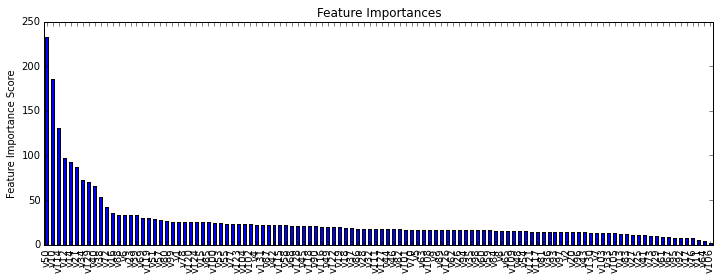

In [106]:
modelfit(xgb1, train2, predictors)

In [107]:
#Predict test set:
y_pred = xgb1.predict_proba(test2[predictors])

# Output to csv
filename = 'submission02.csv'
pd.DataFrame({'ID': test2[IDcol], 'PredictedProb': y_pred[:,1]}).to_csv(filename, index=False)

#THIS SUBMISSION SCORED 0.48769